# Assignment Week 5 - final project code 

## Table of contents

* [Introduction: Business Problem](#intro)
* [Data exploration](#data)
* [Methodology](#methodology)
    * [Data Exploration](#data_exp)
    * [Clustering](#clustering)
* [Results](#results)
* [Discussion](#discuss)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="intro"></a>

### Background to business problem choice

Given the recent years I've spent working with technology startups, I have had the pleasure to spend a large amount of time in WeWork offices around the world. I’m intrigued by the approach they’ve taken in creating spaces to allow many companies to work alongside one another, with the aim of creating local communities in the process. On that basis I've decided to focus on WeWork office locations in London in the UK for this project. On that basis I've decided to focus on WeWork for this capstone project.

### Business problem

[WeWork](https://www.wework.com), currently preparing to be listed on the stockmarket, may have the potential [to be valued around $48bn (£36bn)](https://www.bbc.co.uk/news/business-48127919). That kind of valuation puts them into the realm of high profile tech companies who are deemed to be disrupting their respective areas of business. 

WeWork is an American company, founded in 2010 and headquartered in New York City. Essentially, they provide shared workspaces and have been very popular with technology startups, but also wider. They currently have 651 locations in 115 cities [around the world](https://www.wework.com/en-GB/locations).

The question we aim to answer here is the following: 

>On the assumption that the current 47 London WeWork offices are successful, what links the neighbourhoods in which they are situated and could inform future choices for office locations in London? 
Or asked another way, is there a particular type of neighbourhood in which WeWork offices should be focused?

### Interest 

The target audience for this work is WeWork themselves. Using this data WeWork could start to explore potential future locations for their offices based on previous successes in certain neighbourhood types. 

Note - a key assumption here is that the current WeWork offices are "successful". Success would need to be defined by WeWork i.e. profitable / high occupancy rates etc.

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from urllib.request import urlopen
from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm import tqdm
tqdm.pandas()

import requests
import folium
from folium.plugins import HeatMap

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

## Data exploration <a name="data"></a>

In this section we will explore the data to be used to investigate the question proposed in the introduction, namely a clustering by neighbourhood characteristics of the locations of current WeWork locations in London. 

### Where are WeWork locations today? A worldwide view

Firstly, let us consider the locations of WeWork offices around the world. Using data from the [WeWork office space locations](https://www.wework.com/en-GB/locations) website, we will do the following:

* Scrape city names from the webpage above (using Beautiful Soup)
* Find the latitude and longitude of all locations (using Geopy)
* Plot a worldwide map of all locations (using Folium)

See the following for details of this process and the final map produced.

In [2]:
url = "https://www.wework.com/en-GB/locations"
html = urlopen(url)
soup = BeautifulSoup(html, 'html')
# soup.contents

In [3]:
countries = soup.find_all('a', 'marketLink__countryList__F4CBD')

cities_array = []
cities_array_cs = []

for name in list(countries):
    if '(coming soon)' in name.text:
        cities_array_cs.append(name.text)
    else:
        cities_array.append(name.text)
        
print('Number of cities with offices today: ',len(cities_array))
print('Number of cities with offices coming soon: ',len(cities_array_cs))

Number of cities with offices today:  99
Number of cities with offices coming soon:  16


Note that a number of cities are listed as "Coming soon", these have been removed from the list of cities to be visualised.

We next create a DataFrame to hold the city names and use Geopy to find the locations of each and insert into the main DataFrame. Note that during the creation of this project Geopy was found to be rather unreliable. Hence the data retrieved was read into a CSV file so it could then be read locally as required. The next two sections show the two methods.

#### Getting data via Geopy

In [4]:
df_cities = pd.DataFrame()
df_cities['Name']=cities_array

In [121]:
geolocator = Nominatim(user_agent="office_locations")

In [123]:
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
# df_cities['location'] = df_cities['Name'].apply(geocode)
df_cities['location'] = df_cities['Name'].progress_apply(geocode) # As above but shows progress bar
df_cities['latlong'] = df_cities['location'].apply(lambda x: tuple(x.point) if x else None)

100%|██████████| 99/99 [01:49<00:00,  1.13s/it]


In [126]:
df_cities.to_csv('cities.csv') # Save the data to a local CSV file since Geopy can be intermittent!

#### Alternative - getting data via local CSV file

In [4]:
df_cities = pd.DataFrame()
df_cities = pd.read_csv('cities.csv', index_col=0) # For subsequent use, reading the data from the local CSV file
df_cities = df_cities.dropna()
df_cities.head()

,Name,location,latlong
0,Atlanta,"Atlanta, Fulton County, Georgia, USA","(33.7490987, -84.3901849, 0.0)"
1,Austin,"Austin, Travis County, Texas, USA","(30.2711286, -97.7436995, 0.0)"
2,Boston,"Boston, Suffolk County, Massachusetts, USA","(42.3602534, -71.0582912, 0.0)"
3,Charlotte,"Charlotte, Mecklenburg County, North Carolina,...","(35.2270869, -80.8431268, 0.0)"
4,Chicago,"Chicago, Cook County, Illinois, USA","(41.8755616, -87.6244212, 0.0)"


#### Mapping

In [5]:
map_world = folium.Map(location=[30, 0], zoom_start=1.5)

for latlng, city in zip(df_cities['latlong'], 
                          df_cities['Name']):

    if type(latlng) != tuple:  # Need this scenario when latlong is from csv and hence not a tuple!
        latlng = list(map(float,latlng.strip('()').split(',')))
    
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    if latlng != None:
            folium.CircleMarker(
            [latlng[0], latlng[1]],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_world)  
    
map_world

### Where are WeWork locations today? A London specific view

Secondly, let us consider the locations of WeWork offices in London specifically. Using data from the [WeWork London office space locations webpage](https://www.wework.com/en-GB/l/london), we will do the following:

* Scrape location postcodes from the webpage above (using Beautiful Soup)
* Find the latitude and longitude of all locations (using Geopy)
* Plot a map of all London locations (using Folium)

See the following for details of this process and the final map produced.

In [6]:
url_london = "https://www.wework.com/en-GB/l/london"
html_london = urlopen(url_london)
soup_london = BeautifulSoup(html_london, 'html')

In [7]:
london_locations = soup_london.find_all("div", class_="sc-bxivhb dHqnfT")

london_array = []

for name in list(london_locations):
    london_array.append(name.text)
        
print('Number of locations in London: ',len(london_array))

Number of locations in London:  47


The details of each office need to be split into the main street address, which we will use as the name, and the postcode.

We next create a DataFrame to hold the office names and use Geopy to find the locations of each and insert into the main DataFrame.

In [8]:
london_postcodes = []
london_addresses = []
for office in london_array:
    london_postcodes.append(office.split('London')[-1].replace('UK','').strip(' ,.'))
    london_addresses.append(office.split('London')[0].strip(''))

In [9]:
df_london = pd.DataFrame()
df_london['Name']=london_addresses
df_london['Postcode']=london_postcodes
df_london.head()

,Name,Postcode
0,5 Merchant Square,W2 1NH
1,2 Minster Court,EC3R 7BB
2,51 Eastcheap,EC3M 1JP
3,97 Hackney Rd,E2 8ET
4,12 Moorgate,EC2R 6DA


Per previous comments, during the creation of this project Geopy was found to be rather unreliable. Hence the data retrieved was read into a CSV file so it could then be read locally as required. The next two sections show the two methods.

#### Getting data via Geopy

In [205]:
geocode2 = RateLimiter(geolocator.geocode, min_delay_seconds=1)
df_london['location'] = df_london['Postcode'].progress_apply(geocode2) # Shows progress bar
df_london['latlong'] = df_london['location'].apply(lambda x: tuple(x.point) if x else None)

100%|██████████| 47/47 [00:52<00:00,  1.16s/it]


In [206]:
df_london.head()

,Name,Postcode,location,latlong
0,5 Merchant Square,W2 1NH,"(City of Westminster, W2 1NH, UK, (51.5180379,...","(51.5180379, -0.1713545, 0.0)"
1,2 Minster Court,EC3R 7BB,"(London, EC3R 7BB, UK, (51.5113373470318, -0.0...","(51.5113373470318, -0.0802445243401305, 0.0)"
2,51 Eastcheap,EC3M 1JP,None,None
3,97 Hackney Rd,E2 8ET,"(London Borough of Hackney, E2 8ET, UK, (51.52...","(51.529409776996, -0.0753808705265654, 0.0)"
4,12 Moorgate,EC2R 6DA,"(London, EC2R 6DA, UK, (51.5152573476507, -0.0...","(51.5152573476507, -0.0892781789885309, 0.0)"


Note that a number of postcodes aren't found by Geopy (repeat searches gave the same result). So we needed to get the locations of those missing using the street address.

In [218]:
df_london_missing = df_london[df_london['latlong'].isna()].drop(columns=['location','latlong'])
df_london_missing

,Name,Postcode
2,51 Eastcheap,EC3M 1JP
11,2 Southbank Place,SE1 7NW
39,8 Devonshire Square,EC2M 4PL


In [219]:
df_london_missing['location'] = df_london_missing['Name'].progress_apply(geocode2) # As above but shows progress bar
df_london_missing['latlong'] = df_london_missing['location'].apply(lambda x: tuple(x.point) if x else None)

100%|██████████| 3/3 [00:01<00:00,  2.24it/s]


In [220]:
df_london_missing

,Name,Postcode,location,latlong
2,51 Eastcheap,EC3M 1JP,"(Eastcheap, City of London, London, Greater Lo...","(51.5107535, -0.0854558, 0.0)"
11,2 Southbank Place,SE1 7NW,"(Plaza, 39, Dorcas Street, Southbank, City of ...","(-37.83116545, 144.968784541281, 0.0)"
39,8 Devonshire Square,EC2M 4PL,"(8, Devonshire Square, Jackson, Madison County...","(35.6683191597901, -88.8376228579968, 0.0)"


We then combine all the data together for all the London offices to give a final DataFrame. This is then visualised using Folium.

In [227]:
df_london_all = df_london.dropna()
df_london_all = df_london_all.append(df_london_missing).reset_index(drop=True)
df_london_all.head()

,Name,Postcode,location,latlong
0,5 Merchant Square,W2 1NH,"(City of Westminster, W2 1NH, UK, (51.5180379,...","(51.5180379, -0.1713545, 0.0)"
1,2 Minster Court,EC3R 7BB,"(London, EC3R 7BB, UK, (51.5113373470318, -0.0...","(51.5113373470318, -0.0802445243401305, 0.0)"
3,97 Hackney Rd,E2 8ET,"(London Borough of Hackney, E2 8ET, UK, (51.52...","(51.529409776996, -0.0753808705265654, 0.0)"
4,12 Moorgate,EC2R 6DA,"(London, EC2R 6DA, UK, (51.5152573476507, -0.0...","(51.5152573476507, -0.0892781789885309, 0.0)"
5,77 Leadenhall Street,EC3A 3DE,"(London, EC3A 3DE, UK, (51.5133463830723, -0.0...","(51.5133463830723, -0.0779604206301277, 0.0)"


In [228]:
df_london_all.to_csv('london.csv') # Save the data to a local CSV file if required since Geopy can be intermittent!

#### Alternative - getting data via local CSV file

In [10]:
df_london_all = pd.DataFrame()
df_london_all = pd.read_csv('london.csv', index_col=0) # For subsequent use, reading the data from the local CSV file
df_london_all.reset_index(inplace=True, drop=True)
df_london_all.tail()

,Name,Postcode,location,latlong
42,90 York Way,N1 9AG,"London Borough of Islington, N1 9AG, UK","(51.5346076905406, -0.121900520633922, 0.0)"
43,26 Hatton Garden,EC1N 8BR,"London Borough of Camden, EC1N 8BR, UK","(51.5195795936518, -0.107910005499434, 0.0)"
44,51 Eastcheap,EC3M 1JP,"Eastcheap, City of London, London, Greater Lon...","(51.5107535, -0.0854558, 0.0)"
45,2 Southbank Place,SE1 7NW,"Plaza, 39, Dorcas Street, Southbank, City of M...","(-37.83116545, 144.968784541281, 0.0)"
46,8 Devonshire Square,EC2M 4PL,"8, Devonshire Square, Jackson, Madison County,...","(35.6683191597901, -88.8376228579968, 0.0)"


#### Mapping

In [11]:
london_lat = 51.5074
london_long = -0.1278

In [12]:
map_london = folium.Map(location=[london_lat, london_long], zoom_start=12)

for latlng, office in zip(df_london_all['latlong'], 
                          df_london_all['Name']):
    
    if type(latlng) != tuple:  # Need this scenario when latlong is from csv and hence not a tuple!
        latlng = list(map(float,latlng.strip('()').split(',')))
    
    label = '{}'.format(office)
    label = folium.Popup(label, parse_html=True)
    if latlng != None:
            folium.CircleMarker(
            [latlng[0], latlng[1]],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_london)  
    
map_london

### Foursquare data for each office

The final data set to be gathered is using Foursquare to provide data for the immediate vicinity for each of the 47 offices of interest in London. 

In this section we find up 100 venues in the 400m closest to the offices listed in London. The final output is a DataFrame containing these details which can then be used for clustering in the next step of data analysis (out of scope for this week's assignment.

The steps followed are the following:

* Using the latitude and longitude found in the previous section, query Foursquare using the `explore` [API](https://developer.foursquare.com/docs/api/venues/explore) to find up to 100 local popular venues.
* Group the data produced by office name and shape using one hot encoding.
* Find the 10 most common venues for each office and create a final DataFrame with this data for analysis.

The final DataFrame can be found at the bottom of this section.

In [56]:
CLIENT_ID = 'REMOVED' # your Foursquare ID
CLIENT_SECRET = 'REMOVED' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: REMOVED
CLIENT_SECRET:REMOVED


In [14]:
# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
# function that gets nearby venues

def getNearbyVenues(names, latlong, radius=400):
    LIMIT = 100
    
    venues_list=[]
    for name, latlng in zip(names, latlong):
        
        if type(latlng) != tuple:  # Need this scenario when latlong is from csv and hence not a tuple!
            latlng = list(map(float,latlng.strip('()').split(',')))
        
        print(name, list(latlng)[0], list(latlng)[1])
        lat = list(latlng)[0]
        lng = list(latlng)[1]
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Office Name', 
                  'Office Latitude', 
                  'Office Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Since the offices are relatively close to each other - it is interesting to note how much overlap there is using a 400m radius around each office. The map below shows that, in some cases, this overlap is substantial. We decided to continue with this value since a larger number of offices in a specific area indicates that type of area could be a good place to site offices.

In [16]:
map_london_size = folium.Map(location=[london_lat, london_long], zoom_start=12)

for latlng, office in zip(df_london_all['latlong'], 
                          df_london_all['Name']):
    
    if type(latlng) != tuple:  # Need this scenario when latlong is from csv and hence not a tuple!
        latlng = list(map(float,latlng.strip('()').split(',')))
    
    label = '{}'.format(office)
    label = folium.Popup(label, parse_html=True)
    if latlng != None:
            folium.Circle(
            [latlng[0], latlng[1]],
            radius=400, # Plot circle using Circle (not CircleMarker) to show 400m radius around each office
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_london_size)  
    
map_london_size

In [17]:
df_london_all.head()

,Name,Postcode,location,latlong
0,5 Merchant Square,W2 1NH,"City of Westminster, W2 1NH, UK","(51.5180379, -0.1713545, 0.0)"
1,2 Minster Court,EC3R 7BB,"London, EC3R 7BB, UK","(51.5113373470318, -0.0802445243401305, 0.0)"
2,97 Hackney Rd,E2 8ET,"London Borough of Hackney, E2 8ET, UK","(51.529409776996, -0.0753808705265654, 0.0)"
3,12 Moorgate,EC2R 6DA,"London, EC2R 6DA, UK","(51.5152573476507, -0.0892781789885309, 0.0)"
4,77 Leadenhall Street,EC3A 3DE,"London, EC3A 3DE, UK","(51.5133463830723, -0.0779604206301277, 0.0)"


In [18]:
london_venues = getNearbyVenues(names=df_london_all['Name'],
                                latlong=df_london_all['latlong']
                                )
london_venues.head()

5 Merchant Square  51.5180379 -0.1713545
2 Minster Court  51.5113373470318 -0.0802445243401305
97 Hackney Rd  51.529409776996 -0.0753808705265654
12 Moorgate  51.5152573476507 -0.0892781789885309
77 Leadenhall Street  51.5133463830723 -0.0779604206301277
The Bard, Shoreditch  51.5229407264196 -0.0784646120558583
21 Soho Square  51.5155972418882 -0.131553517097588
41 Blackfriars Road  51.4966461 -0.0995819
120 Moorgate  51.5191215976723 -0.0885812010133903
The Hewitt, Shoreditch  51.5220564 -0.081771
10 East Road  51.5272802404136 -0.0875806033120571
123 Buckingham Palace Road  51.493078125 -0.14681935
1 Waterhouse Square  51.5187245333333 -0.109628533333333
Aldgate Tower, 2 Leman Street,  51.5148743358659 -0.0719950469255574
115 Mare Street  51.5376453848606 -0.0572825791259911
16 Great Chapel St,  51.5151727 -0.1342188
14 Gray's Inn Road  51.5189251408874 -0.111382048329653
12 Hammersmith Grove  51.4942183091413 -0.225692027308601
1 St. Katharine's Way  51.5079079207978 -0.07356876987

,Office Name,Office Latitude,Office Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,5 Merchant Square,51.518038,-0.171354,Virgin Active,51.518988,-0.173483,Gym / Fitness Center
1,5 Merchant Square,51.518038,-0.171354,Frontline Club,51.516932,-0.172523,Bar
2,5 Merchant Square,51.518038,-0.171354,Kioskafé,51.516914,-0.172626,Bookstore
3,5 Merchant Square,51.518038,-0.171354,BrewDog Paddington,51.518948,-0.170546,Beer Bar
4,5 Merchant Square,51.518038,-0.171354,Java U Paddington,51.516217,-0.174553,Coffee Shop


In [19]:
print(london_venues.shape)
print('There are {} unique categories within this data for London.'.format(len(london_venues['Venue Category'].unique())))

(3450, 7)
There are 235 unique categories within this data for London.


In [20]:
london_venues.groupby('Office Name').count()

,Office Latitude,Office Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Office Name,,,,,,
1 Fore Street Avenue,45,45,45,45,45,45
1 Mark Square,100,100,100,100,100,100
1 Poultry,100,100,100,100,100,100
"1 Primrose Street,",98,98,98,98,98,98
1 St. Katharine's Way,30,30,30,30,30,30
1 Waterhouse Square,62,62,62,62,62,62
10 Devonshire Square,100,100,100,100,100,100
10 East Road,58,58,58,58,58,58
115 Mare Street,82,82,82,82,82,82


In [21]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add office name column back to dataframe
london_onehot['Office Name'] = london_venues['Office Name'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

print('Shape is:', london_onehot.shape)
london_onehot.head()

Shape is: (3450, 236)


,Office Name,Adult Boutique,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Camera Store,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,College Cafeteria,College Gym,Colombian Restaurant,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Deli / Bodega,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Lawyer,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Organic Grocery,Other Nightlife,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Platform,Plaza,Poke Place,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Scottish Restaurant,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South American Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Squash Court,Sri Lankan Restaurant,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Tour Provider,Tourist Information Center,Trail,Train Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veneto Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant
0,5 Merchant Square,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5 Merchant Square,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [22]:
london_grouped = london_onehot.groupby('Office Name').mean().reset_index()
print('Shape is:', london_grouped.shape)
london_grouped.head()

Shape is: (47, 236)


,Office Name,Adult Boutique,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Camera Store,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,College Cafeteria,College Gym,Colombian Restaurant,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Deli / Bodega,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Lawyer,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Organic Grocery,Other Nightlife,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Platform,Plaza,Poke Place,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Scottish Restaurant,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South American Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Squash Court,Sri Lankan Restaurant,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Tour Provider,Tourist Information Center,Trail,Train Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veneto Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant
0,1 Fore Street Avenue,0.0,0.0,0.0,0.0,0.0,0.000000,0.066667,0.0,0.0,0.000000,0.00,0.00,0.0,0.00,0.000000,0.00,0.000000,0.0,0.00,0.00,0.0,0.0,0.00,0.022222,0.00,0.0,0.022222,0.0,0.000000,0.0,0.0,0.0,0.000000,0.022222,0.0,0.0,0.00,0.022222,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.022222,0.022222,0.00,0.133333,0.0,0.0,0.0,0.0,0.0,0.0,0.022222,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.022222,0.00,0.0,0.00,0.00,0.0,0.000000,0.0,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.022222,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.022222,0.0,0.000000,0.022222,0.00000

In [23]:
#  Function to return most common venues

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Office Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Office Name'] = london_grouped['Office Name']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Office Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1 Fore Street Avenue,Coffee Shop,Hotel,Art Gallery,Sandwich Place,Steakhouse,Yoga Studio,Peruvian Restaurant,Botanical Garden,Boxing Gym,Clothing Store
1,1 Mark Square,Coffee Shop,Hotel,Restaurant,Cocktail Bar,Bar,Italian Restaurant,Gym / Fitness Center,Café,Pub,Pizza Place
2,1 Poultry,Coffee Shop,Italian Restaurant,Gym / Fitness Center,Asian Restaurant,Sandwich Place,Pub,Seafood Restaurant,French Restaurant,Steakhouse,Bar
3,"1 Primrose Street,",Coffee Shop,Food Truck,Pub,Bar,Hotel,Clothing Store,Pizza Place,Gym / Fitness Center,Wine Bar,Breakfast Spot
4,1 St. Katharine's Way,Hotel,Castle,Modern European Restaurant,French Restaurant,Gift Shop,Souvenir Shop,Exhibit,Museum,Park,Scenic Lookout
5,1 Waterhouse Square,Coffee Shop,Sandwich Place,Pub,Burrito Place,Beer Bar,Bookstore,Food Truck,Sushi Restaurant,Salad Place,Italian Restaurant
6,10 Devonshire Square,Coffee Shop,Salad Place,Pub,Restaurant,Sushi Restaurant,Italian Restaurant,Mediterranean Restaurant,Cocktail Bar,Breakfast Spot,Gym / Fitness Center
7,10 East Road,Coffee Shop,Pub,Hotel,Café,Restaurant,Beer Bar,Burger Joint,Mediterranean Restaurant,Furniture / Home Store,Fried Chicken Joint
8,115 Mare Street,Café,Bakery,Coffee Shop,Pub,Pizza Place,Cocktail Bar,Art Gallery,Restaurant,Bookstore,Bus Stop
9,119 Marylebone Road,Gastropub,Pizza Place,Hotel,Sandwich Place,Pub,Thai Restaurant,Coffee Shop,Burger Joint,Garden,Juice Bar


In [25]:
neighborhoods_venues_sorted.to_csv('neighborhoods_venues_sorted.csv')

In [26]:
# neighborhoods_venues_sorted2 = pd.read_csv('neighborhoods_venues_sorted.csv', index_col=0)
# neighborhoods_venues_sorted2.head()

### Data summary

We now have the datasets required in order to start analysis. In summary these are the following:

In [27]:
print('Data for all WeWork locations, with {} offices in London found.'.format(len(df_london_all)))
df_london_all.head()


Data for all WeWork locations, with 47 offices in London found.


,Name,Postcode,location,latlong
0,5 Merchant Square,W2 1NH,"City of Westminster, W2 1NH, UK","(51.5180379, -0.1713545, 0.0)"
1,2 Minster Court,EC3R 7BB,"London, EC3R 7BB, UK","(51.5113373470318, -0.0802445243401305, 0.0)"
2,97 Hackney Rd,E2 8ET,"London Borough of Hackney, E2 8ET, UK","(51.529409776996, -0.0753808705265654, 0.0)"
3,12 Moorgate,EC2R 6DA,"London, EC2R 6DA, UK","(51.5152573476507, -0.0892781789885309, 0.0)"
4,77 Leadenhall Street,EC3A 3DE,"London, EC3A 3DE, UK","(51.5133463830723, -0.0779604206301277, 0.0)"


In [28]:
print('Data for the 10 most common venues for each London office, with {} venue categories seen in total.'.format(len(london_venues['Venue Category'].unique())))
neighborhoods_venues_sorted

Data for the 10 most common venues for each London office, with 235 venue categories seen in total.


,Office Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1 Fore Street Avenue,Coffee Shop,Hotel,Art Gallery,Sandwich Place,Steakhouse,Yoga Studio,Peruvian Restaurant,Botanical Garden,Boxing Gym,Clothing Store
1,1 Mark Square,Coffee Shop,Hotel,Restaurant,Cocktail Bar,Bar,Italian Restaurant,Gym / Fitness Center,Café,Pub,Pizza Place
2,1 Poultry,Coffee Shop,Italian Restaurant,Gym / Fitness Center,Asian Restaurant,Sandwich Place,Pub,Seafood Restaurant,French Restaurant,Steakhouse,Bar
3,"1 Primrose Street,",Coffee Shop,Food Truck,Pub,Bar,Hotel,Clothing Store,Pizza Place,Gym / Fitness Center,Wine Bar,Breakfast Spot
4,1 St. Katharine's Way,Hotel,Castle,Modern European Restaurant,French Restaurant,Gift Shop,Souvenir Shop,Exhibit,Museum,Park,Scenic Lookout
5,1 Waterhouse Square,Coffee Shop,Sandwich Place,Pub,Burrito Place,Beer Bar,Bookstore,Food Truck,Sushi Restaurant,Salad Place,Italian Restaurant
6,10 Devonshire Square,Coffee Shop,Salad Place,Pub,Restaurant,Sushi Restaurant,Italian Restaurant,Mediterranean Restaurant,Cocktail Bar,Breakfast Spot,Gym / Fitness Center
7,10 East Road,Coffee Shop,Pub,Hotel,Café,Restaurant,Beer Bar,Burger Joint,Mediterranean Restaurant,Furniture / Home Store,Fried Chicken Joint
8,115 Mare Street,Café,Bakery,Coffee Shop,Pub,Pizza Place,Cocktail Bar,Art Gallery,Restaurant,Bookstore,Bus Stop
9,119 Marylebone Road,Gastropub,Pizza Place,Hotel,Sandwich Place,Pub,Thai Restaurant,Coffee Shop,Burger Joint,Garden,Juice Bar


## Methodology <a name="methodology"></a>

For this project we will use the following methodology:

* Data has been collected from the WeWork website for London based offices and exact locations added 
* The areas around each office will be characterised using data from Foursquare for venue types in a 400m radius around each. This radius was chosen as the ["ped shed"](https://pedshed.net/?page_id=5) which is deemed as equivalent to 5 mins walk.
* The data will be explored using heatmapping and K-means clustering in order to find similarities between the localities of the various WeWork offices in London.

### Data Exploration <a name="data_exp"></a>

In this section we will explore the data in more detail and then use K-means clustering to group the office areas.

Initially it is of interest to see how closely grouped the offices are, since this indicates areas which are not served currently by WeWork. As noted previously some offices are quite close to each other and it might make sense to avoid too high a density of offices in certain areas. This information, used in combination with the area types could help in finding potential new areas for WeWork offices.

In [29]:
heat_data = df_london_all['latlong'].apply(lambda x: list(map(float,x.strip('()').split(',')))[0:2])

In [30]:
# create map
map_heat = folium.Map(location=[london_lat, london_long], zoom_start=12)

HeatMap(heat_data).add_to(map_heat)

map_heat

Perhaps unsurprisingly, the highest density is seen around the City of London, around London Liverpool Street train station. Other hot spots are noted around the centre of the city, including in close proximity to areas more easily accessed by commuters from outside the city such as London Paddington, London Bridge and Kings Cross train stations and the Hammersmith area (at the end of M4 motorway so more easily accessed by car). Also to the west of the City around Tottenham Court Road / Chancery Lane.

### Clustering <a name="clustering"></a>

#### Investigating the number of clusters to use

In [33]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(london_grouped.drop('Office Name', 1))
    Sum_of_squared_distances.append(km.inertia_)

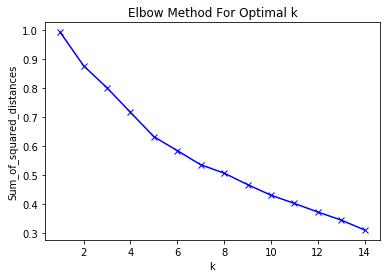

In [34]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Based on this, with a slight elbow seen at 5, we will use k = 5.

#### Clustering implementation

In [35]:
# set number of clusters
kclusters = 5

london_grouped_clustering = london_grouped.drop('Office Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:len(london_grouped)] 

array([3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 0, 0, 3, 3, 3, 1,
       1, 3, 4, 3, 3, 1, 0, 1, 3, 0, 3, 3, 1, 3, 3, 3, 1, 2, 3, 3, 3, 1,
       1, 3, 3], dtype=int32)

In [36]:
neighborhoods_venues_sorted.head()

,Office Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1 Fore Street Avenue,Coffee Shop,Hotel,Art Gallery,Sandwich Place,Steakhouse,Yoga Studio,Peruvian Restaurant,Botanical Garden,Boxing Gym,Clothing Store
1,1 Mark Square,Coffee Shop,Hotel,Restaurant,Cocktail Bar,Bar,Italian Restaurant,Gym / Fitness Center,Café,Pub,Pizza Place
2,1 Poultry,Coffee Shop,Italian Restaurant,Gym / Fitness Center,Asian Restaurant,Sandwich Place,Pub,Seafood Restaurant,French Restaurant,Steakhouse,Bar
3,"1 Primrose Street,",Coffee Shop,Food Truck,Pub,Bar,Hotel,Clothing Store,Pizza Place,Gym / Fitness Center,Wine Bar,Breakfast Spot
4,1 St. Katharine's Way,Hotel,Castle,Modern European Restaurant,French Restaurant,Gift Shop,Souvenir Shop,Exhibit,Museum,Park,Scenic Lookout


In [37]:
df_london_all.head()

,Name,Postcode,location,latlong
0,5 Merchant Square,W2 1NH,"City of Westminster, W2 1NH, UK","(51.5180379, -0.1713545, 0.0)"
1,2 Minster Court,EC3R 7BB,"London, EC3R 7BB, UK","(51.5113373470318, -0.0802445243401305, 0.0)"
2,97 Hackney Rd,E2 8ET,"London Borough of Hackney, E2 8ET, UK","(51.529409776996, -0.0753808705265654, 0.0)"
3,12 Moorgate,EC2R 6DA,"London, EC2R 6DA, UK","(51.5152573476507, -0.0892781789885309, 0.0)"
4,77 Leadenhall Street,EC3A 3DE,"London, EC3A 3DE, UK","(51.5133463830723, -0.0779604206301277, 0.0)"


In [38]:
# add clustering labels
try:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except: # for scenario where we are rerunning this and the column already exists
    neighborhoods_venues_sorted.drop(columns='Cluster Labels', inplace=True) 
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

london_merged = df_london_all
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Office Name'), on='Name')

london_merged.head() 

,Name,Postcode,location,latlong,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,5 Merchant Square,W2 1NH,"City of Westminster, W2 1NH, UK","(51.5180379, -0.1713545, 0.0)",1,Coffee Shop,Hotel,Beer Bar,Middle Eastern Restaurant,Pub,Pharmacy,Persian Restaurant,Sandwich Place,Fish & Chips Shop,Garden
1,2 Minster Court,EC3R 7BB,"London, EC3R 7BB, UK","(51.5113373470318, -0.0802445243401305, 0.0)",1,Hotel,Coffee Shop,Garden,Gym / Fitness Center,Salad Place,Restaurant,Pub,Cocktail Bar,Beer Bar,Hotel Bar
2,97 Hackney Rd,E2 8ET,"London Borough of Hackney, E2 8ET, UK","(51.529409776996, -0.0753808705265654, 0.0)",3,Vietnamese Restaurant,Café,Coffee Shop,Arts & Crafts Store,Cocktail Bar,Restaurant,Bar,Grocery Store,Pub,Pizza Place
3,12 Moorgate,EC2R 6DA,"London, EC2R 6DA, UK","(51.5152573476507, -0.0892781789885309, 0.0)",3,Coffee Shop,Pub,Sandwich Place,Restaurant,French Restaurant,Café,Gym / Fitness Center,Steakhouse,Bakery,Italian Restaurant
4,77 Leadenhall Street,EC3A 3DE,"London, EC3A 3DE, UK","(51.5133463830723, -0.0779604206301277, 0.0)",1,Hotel,Sandwich Place,Pub,Coffee Shop,Cocktail Bar,Café,Gym / Fitness Center,Sushi Restaurant,Salad Place,Thai Restaurant


In [39]:
# create map
map_clusters = folium.Map(location=[london_lat, london_long], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.spring(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

for latlng, office, cluster in zip(london_merged['latlong'],
                                   london_merged['Name'],
                                   london_merged['Cluster Labels']):
    
    if type(latlng) != tuple:  # Need this scenario when latlong is from csv and hence not a tuple!
        latlng = list(map(float,latlng.strip('()').split(',')))
    
    label = '{}'.format(office)
    label = folium.Popup(label, parse_html=True)
    if latlng != None:
            folium.CircleMarker(
            [latlng[0], latlng[1]],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.8,
            parse_html=False).add_to(map_clusters)
            
map_clusters

We note that we see 3 main groups, with a couple of outliers with single member lists. The larger groups are the 4th, 1st and 2nd groups in size order. 

In [40]:
london_merged.groupby(['Cluster Labels']).count()

,Name,Postcode,location,latlong,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,
0,5,5,5,5,5,5,5,5,5,5,5,5,5,5
1,10,10,10,10,10,10,10,10,10,10,10,10,10,10
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,30,30,30,30,30,30,30,30,30,30,30,30,30,30
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [42]:
# Use this if redoing the clustering
# london_grouped.drop(columns='Cluster Labels', inplace=True)

In [43]:
london_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

In [44]:
character = london_grouped.groupby('Cluster Labels').mean()

In [45]:
character.head()

,Adult Boutique,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Camera Store,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,College Cafeteria,College Gym,Colombian Restaurant,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Deli / Bodega,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Lawyer,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Organic Grocery,Other Nightlife,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Platform,Plaza,Poke Place,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Scottish Restaurant,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South American Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Squash Court,Sri Lankan Restaurant,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Tour Provider,Tourist Information Center,Trail,Train Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veneto Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.00000,0.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,0.012722,0.000000,0.000000,0.000000,0.014124,0.007195,0.027444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024846,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002597,0.030846,0.000000,0.000000,0.000000,0.004597,0.000000,0.000000,0.000000,0.

In [46]:
char_t = character.T
# char_t.iloc[:,[3,0,1]].plot(kind = 'line', figsize=(20,8))

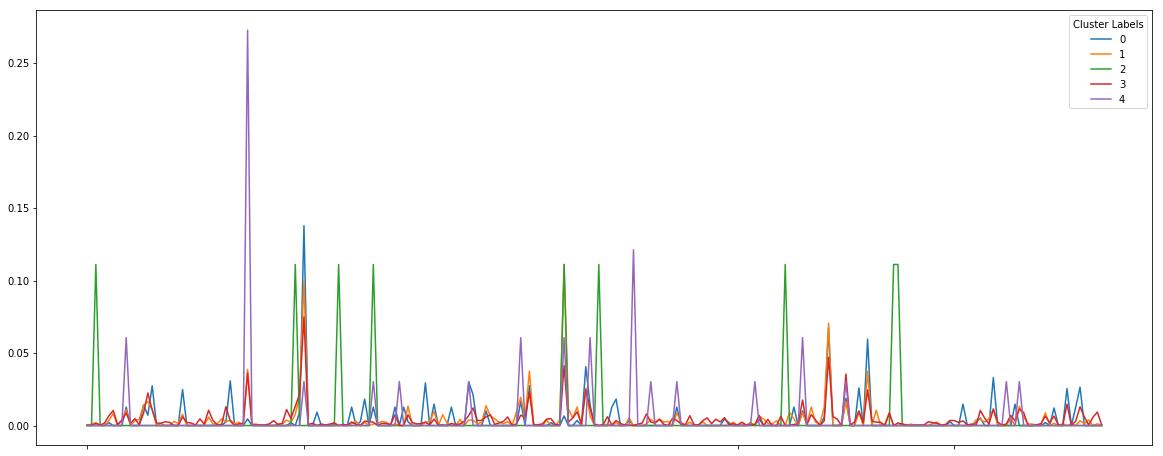

In [47]:
character.T.plot(kind = 'line', figsize=(20,8))

In [48]:
#  What are the significant values for each cluster? use value below to find them in the list of many venue types
character[character > 0.06]

,Adult Boutique,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Beer Bar,Beer Garden,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Camera Store,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Castle,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,College Cafeteria,College Gym,Colombian Restaurant,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Deli / Bodega,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Lawyer,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Organic Grocery,Other Nightlife,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Platform,Plaza,Poke Place,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Scottish Restaurant,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Snack Place,Soba Restaurant,Soccer Field,Social Club,Soup Place,South American Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Squash Court,Sri Lankan Restaurant,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Tour Provider,Tourist Information Center,Trail,Train Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veneto Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant
Cluster Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.137899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Look for the highest values for the clusters.

In [49]:
char_t.columns= ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
char_t.head()

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
Adult Boutique,0.0,0.00000,0.000000,0.000392,0.0
African Restaurant,0.0,0.00101,0.000000,0.000000,0.0
American Restaurant,0.0,0.00201,0.111111,0.001445,0.0
Arcade,0.0,0.00000,0.000000,0.000397,0.0
Arepa Restaurant,0.0,0.00000,0.000000,0.001587,0.0


In [50]:
cl4_top = char_t['Cluster 4'].sort_values(ascending=False).head(10)
cl4_top

Coffee Shop             0.074963
Pub                     0.047101
Hotel                   0.041306
Café                    0.036212
Restaurant              0.035534
Italian Restaurant      0.024708
Sandwich Place          0.024556
Gym / Fitness Center    0.022626
Bar                     0.022435
Cocktail Bar            0.021826
Name: Cluster 4, dtype: float64

In [51]:
cl2_top = char_t['Cluster 2'].sort_values(ascending=False).head(10)
cl2_top

Hotel                   0.111153
Coffee Shop             0.099703
Pub                     0.070691
Café                    0.038774
Gym / Fitness Center    0.037559
Sandwich Place          0.037426
Italian Restaurant      0.025706
Cocktail Bar            0.021087
Grocery Store           0.019511
Bar                     0.016608
Name: Cluster 2, dtype: float64

In [52]:
cl1_top = char_t['Cluster 1'].sort_values(ascending=False).head(10)
cl1_top

Coffee Shop             0.137899
Pub                     0.067223
Sandwich Place          0.059563
Italian Restaurant      0.040638
Sushi Restaurant        0.033142
Burrito Place           0.030846
Food Truck              0.030041
Falafel Restaurant      0.029444
Beer Bar                0.027444
Gym / Fitness Center    0.027444
Name: Cluster 1, dtype: float64

In [53]:
cl3_top = char_t['Cluster 3'].sort_values(ascending=False).head(10)
cl3_top

Construction & Landscaping    0.111111
Hotel                         0.111111
Shoe Store                    0.111111
Shipping Store                0.111111
Clothing Store                0.111111
Deli / Bodega                 0.111111
Pet Store                     0.111111
Jewelry Store                 0.111111
American Restaurant           0.111111
Creperie                      0.000000
Name: Cluster 3, dtype: float64

In [54]:
cl5_top = char_t['Cluster 5'].sort_values(ascending=False).head(10)
cl5_top

Café                    0.272727
Light Rail Station      0.121212
Grocery Store           0.060606
Hotel                   0.060606
Japanese Restaurant     0.060606
Pizza Place             0.060606
Asian Restaurant        0.060606
Food Truck              0.030303
Dumpling Restaurant     0.030303
Taiwanese Restaurant    0.030303
Name: Cluster 5, dtype: float64

Merge all together to show the key differences in each.

In [55]:
cl_all = pd.DataFrame(cl4_top).reset_index()
cl_all = cl_all.merge(pd.DataFrame(cl2_top).reset_index(), how='outer', on='index')
cl_all = cl_all.merge(pd.DataFrame(cl1_top).reset_index(), how='outer', on='index')
cl_all = cl_all.merge(pd.DataFrame(cl3_top).reset_index(), how='outer', on='index')
cl_all = cl_all.merge(pd.DataFrame(cl5_top).reset_index(), how='outer', on='index')
cl_all.set_index('index', inplace=True)
cl_all

,Cluster 4,Cluster 2,Cluster 1,Cluster 3,Cluster 5
index,,,,,
Coffee Shop,0.074963,0.099703,0.137899,NaN,NaN
Pub,0.047101,0.070691,0.067223,NaN,NaN
Hotel,0.041306,0.111153,NaN,0.111111,0.060606
Café,0.036212,0.038774,NaN,NaN,0.272727
Restaurant,0.035534,NaN,NaN,NaN,NaN
Italian Restaurant,0.024708,0.025706,0.040638,NaN,NaN
Sandwich Place,0.024556,0.037426,0.059563,NaN,NaN
Gym / Fitness Center,0.022626,0.037559,0.027444,NaN,NaN
Bar,0.022435,0.016608,NaN,NaN,NaN


## Results <a name="results"></a>

In this analysis we have explored the locations of the WeWork offices in London. Using clustering based on venues within walking distance (defined as 400m radius) we have clustered the offices into five groups. Of these groups, three have more than one member.

Comparing the three largest clusters (clusters 4, 2 and 1 in descending order) we note the following: 

* The three largest clusters share a number of common features. Coffee shops and pubs come in the top 5 of all three.
* Being specific about the type of each area beyond these shared features is difficult but we note a few differences using the top ten venue types for each cluster:
    * Cluster 4 (label 3) has the "core" venue types one might except, but has less variety in other areas i.e. types of restaurants and grocery stores.
    * Cluster 2 (label 1) has a relatively large number of Coffee Shops compared to the other clusters. But a wide range of food offerings and grocery stores.
    * Cluster 1 (label 0) shows fewer hotels and grocery stores than 4 and 2. But quite a variety of food providers.
    * Clusters 3 and 5 only have one member each and the reason for this is evident in their characteristics. Cluster 3 shows construction and shopping areas. Cluster 5 shows a large range of asian themed eating venues, plus a light rail station.

## Discussion <a name="discuss"></a>

Based on our results we have identified three types of areas where WeWork offices appear to have been successful. As noted at the beginning of this project, a key assumption here is that the current WeWork offices are "successful". This assumption would need to be validated with data from WeWork highlighting offices which, by their own metric, are defined as successful. Potential metrics to use here could be profitability or high occupancy rates.  Or potentially even other metrics measuring the outcomes desired from such working spaces, potentially harder to quantify, such as startup success rates, innovations or partnering successes.

In theory, using these results, WeWork could characterise other areas where they might be considering new offices to see if they are similar to those seen here, influencing their decision to create a new office there or not.

One thing noted during the exploration of the data and in particular a heat map of the offices was the higher incidence of offices around key commuter links into and out of the capital. In further work it would make sense to quantify this and add into the clustering methodology.

## Conclusion <a name="conclusion"></a>

The aim of this project was to explore the following question:

> On the assumption that the current 47 London WeWork offices are successful, what links the areas in which they are situated and could inform future choices for office locations in London? Or asked another way, is there a particular type or number of types of neighbourhoods in which WeWork offices should be focused?

We have been able to show that the current offices fall into three main types of neighbourhood based on the types of venues in those neighbourhoods. This analysis might allow the key stakeholder here, WeWork themselves, to rate potential locations for future offices.

Key things to explore further would be how to define / subset the more successful offices to better inform the clustering process. Also, to explore the distances from commuter train stations / key roads which will most likely have impact here also.